<center><b><font size=6>Data Exploration and Pre-processing<b><center>

This notebook performs the following tasks for analyzing attack data.

0. **Install Dependencies**
1. **Dataset Preparation**
2. **Temporal Analysis** 
3. **Session Analysis**
4. **Intent Distribution**
5. **Text Representation**
6. **Error Reporting** 

<center><b><font size=5>Install Dependencies<b><center>

In [1]:
!python ../scripts/install_dependencies.py section1

Installing packages for section1: pyarrow, pandas, numpy, matplotlib, seaborn, wordcloud
  Using cached wordcloud-1.9.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (488 kB)


<center><b><font size=5>Dataset Preparation<b><center>

- Load the dataset (`ssh_attacks.parquet`) into a Pandas DataFrame.

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
from collections import Counter 
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

In [31]:
SSH_Attacks = pd.read_parquet("../data/processed/ssh_attacks_decoded.parquet")

In [32]:
SSH_Attacks

,session_id,full_session,first_timestamp,Set_Fingerprint
0,0,"[enable, system, sh, sh, cat, proc, mounts, bi...",2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]"
1,1,"[enable, system, sh, sh, cat, proc, mounts, bi...",2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]"
2,2,"[enable, system, sh, sh, cat, proc, mounts, bi...",2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]"
3,3,"[enable, system, sh, sh, cat, proc, mounts, bi...",2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]"
4,4,"[enable, system, sh, sh, cat, proc, mounts, bi...",2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]"
...,...,...,...,...
233030,233042,"[cat, proc, cp, grep, name, echo, passwd, bash...",2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]"
233031,233043,"[cat, proc, cp, grep, name, echo, passwd, bash...",2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]"
233032,233044,"[cat, proc, cp, grep, name, echo, ss, passwd, ...",2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]"
233033,233045,"[cat, proc, cp, grep, name, echo, passwd, bash...",2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]"


- Inspect the dataset schema: check for missing values, anomalies, or inconsistencies.

In [33]:
import pandas as pd
import numpy as np

# Assuming SSH_Attacks is your DataFrame
# Example: SSH_Attacks = pd.read_csv('path_to_ssh_attacks_data.csv')

# 1. Inspect the basic structure (columns and data types)
print("Dataset Structure:")
print(SSH_Attacks.info())

# 2. Check for missing values
print("\nMissing Values:")
print(SSH_Attacks.isnull().sum())  # Display the number of missing values per column

# 3. Check for duplicates
print("\nDuplicate Rows:")
# Handle unhashable types in columns (e.g., lists or arrays)
# Convert columns that might be unhashable into a hashable format before checking for duplicates
# We will convert columns with object types that are not lists or arrays to string (if needed).
# print(SSH_Attacks['Set_Fingerprint'].value_counts())

Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233035 entries, 0 to 233034
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   session_id       233035 non-null  int64              
 1   full_session     233035 non-null  object             
 2   first_timestamp  233035 non-null  datetime64[ns, UTC]
 3   Set_Fingerprint  233035 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 7.1+ MB
None

Missing Values:
session_id         0
full_session       0
first_timestamp    0
Set_Fingerprint    0
dtype: int64

Duplicate Rows:


In [8]:
# If the column already contains lists, apply explode directly
all_classes = SSH_Attacks['Set_Fingerprint'].explode().str.strip()

# Now, count the occurrences of each class
class_counts = all_classes.value_counts()

print(class_counts)

Discovery          232145
Persistence        211295
Execution           92927
Defense Evasion     18999
Harmless             2206
Other                 327
Impact                 27
Name: Set_Fingerprint, dtype: int64


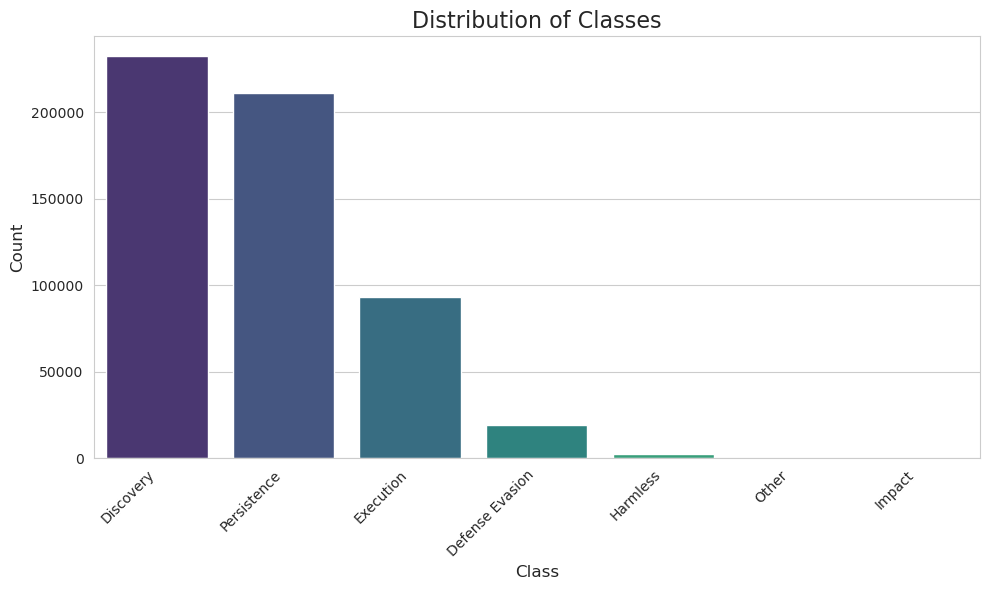

In [34]:
plt.figure(figsize=(10, 6))

# Create the bar plot
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

# Add labels and title
plt.title('Distribution of Classes', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

<center><b><font size=5>Temporal Analysis<b><center>

- Convert `first_timestamp` to a datetime format.

In [35]:
# Ensure the first_timestamp column is in datetime format
SSH_Attacks['first_timestamp'] = pd.to_datetime(SSH_Attacks['first_timestamp'])



- Analyze attack frequencies over time: hourly, daily, monthly trends.

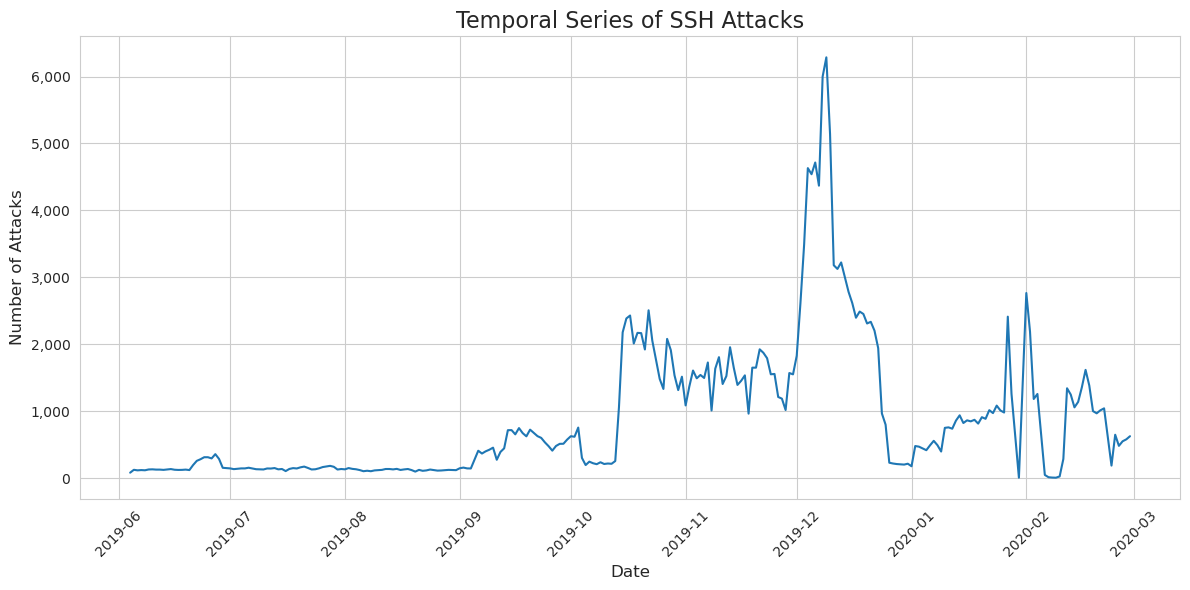

In [36]:
# Aggregate data by date
temporal_series = (
    SSH_Attacks.groupby(SSH_Attacks['first_timestamp'].dt.date)
    .size()
    .reset_index(name='attack_count')
)

# Rename columns for clarity
temporal_series.rename(columns={'first_timestamp': 'date'}, inplace=True)

# Define a formatter for the y-axis
def thousands_formatter(x, _):
    return f"{int(x):,}"

# Plot the data
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=temporal_series, x='date', y='attack_count')

# Improve x and y-axis formatting
plt.title('Temporal Series of SSH Attacks', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Add tight layout for better spacing
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


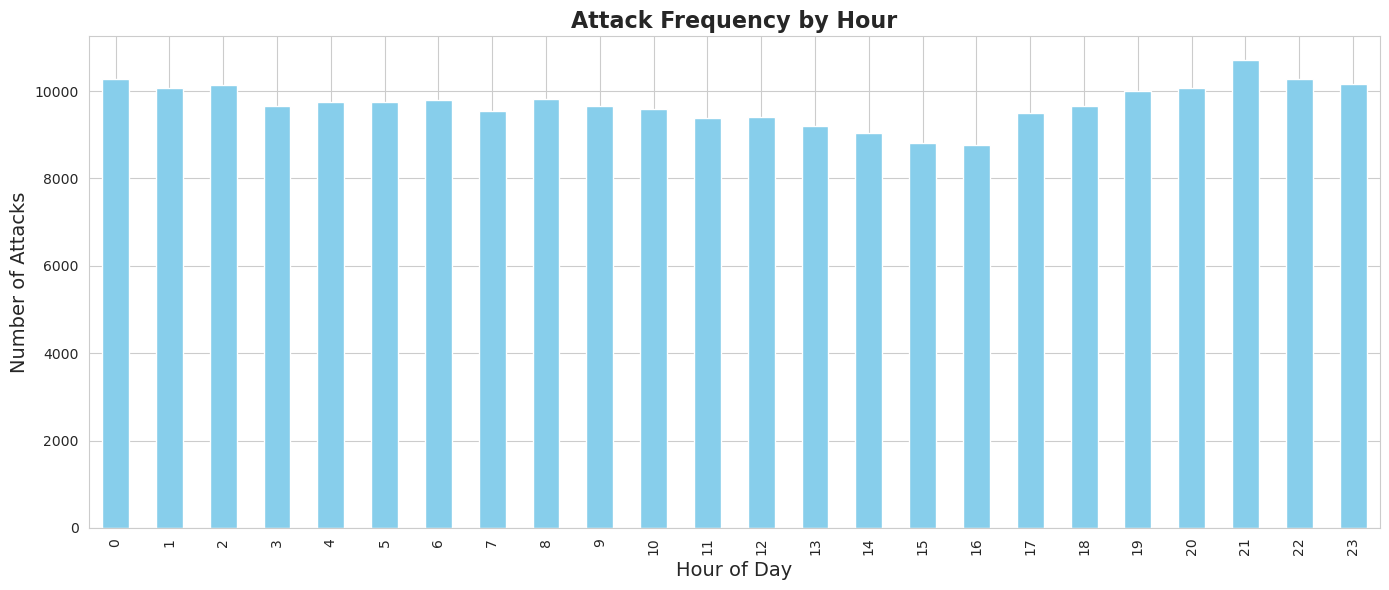

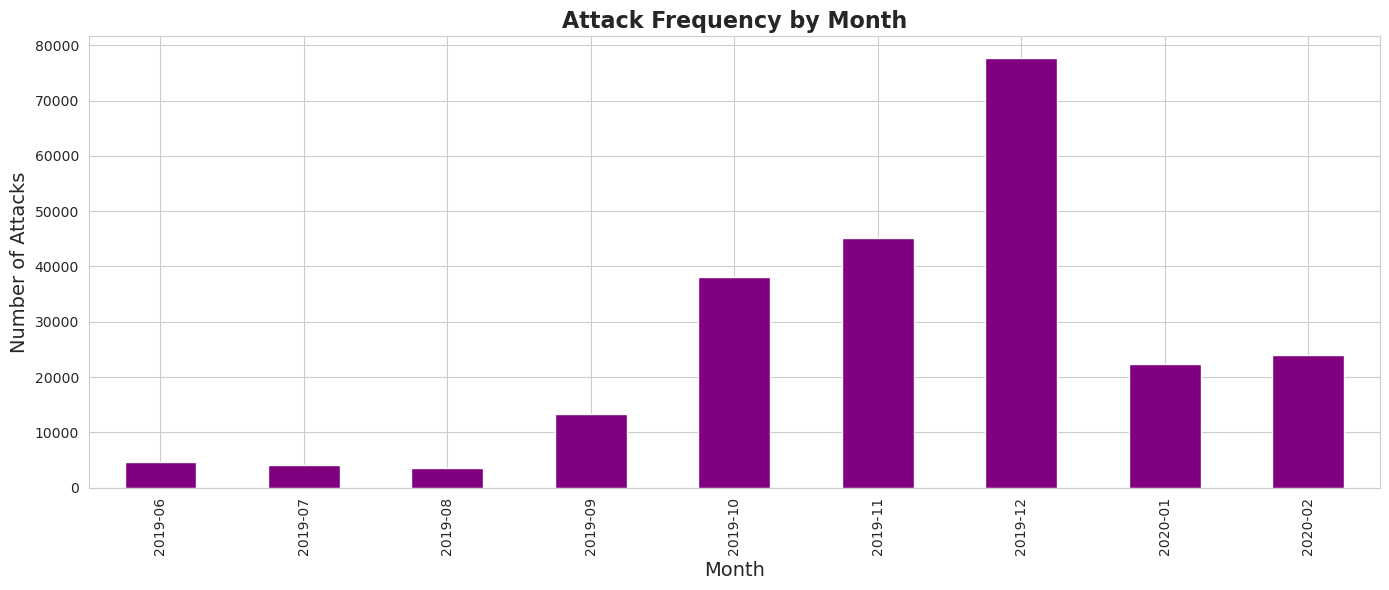

In [37]:
# Analyze attack frequencies over time: hourly, daily, monthly trends
SSH_Attacks['hour'] = SSH_Attacks['first_timestamp'].dt.hour
SSH_Attacks['month'] = SSH_Attacks['first_timestamp'].dt.to_period('M')

# Plot time-series graphs for attack distributions
plt.figure(figsize=(14, 6))
SSH_Attacks['hour'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Attack Frequency by Hour', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Number of Attacks', fontsize=14)
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))
SSH_Attacks['month'].value_counts().sort_index().plot(kind='bar', color='purple')
plt.title('Attack Frequency by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Attacks', fontsize=14)
plt.tight_layout()
plt.show()


- Plot time-series graphs for attack distributions.

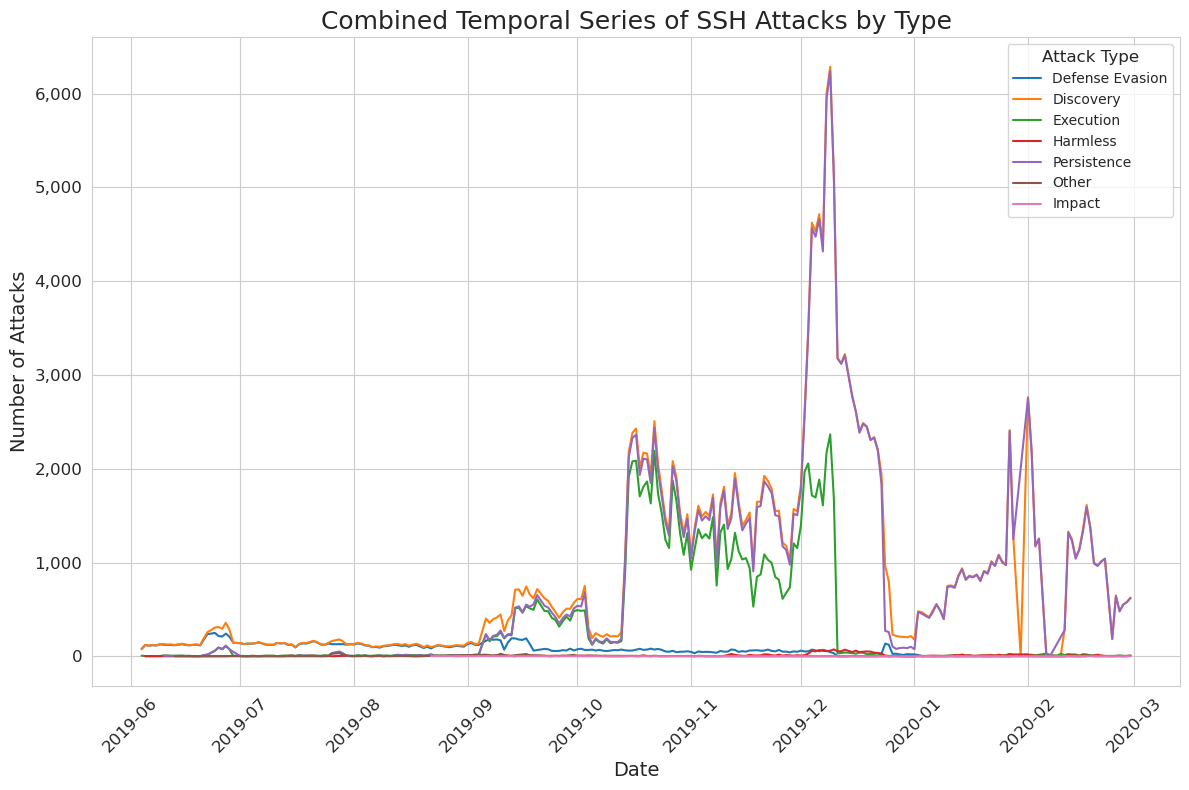

In [38]:
# Ensure the first_timestamp column is in datetime format
SSH_Attacks['first_timestamp'] = pd.to_datetime(SSH_Attacks['first_timestamp'])

# Explode the Set_Fingerprint column to create separate rows for each intent
SSH_Attacks_exploded = SSH_Attacks.explode('Set_Fingerprint')

# Group by Set_Fingerprint and date to count occurrences
grouped_SSH_Attacks = (
    SSH_Attacks_exploded.groupby([SSH_Attacks_exploded['first_timestamp'].dt.date, 'Set_Fingerprint'])
    .size()
    .reset_index(name='attack_count')
)

# Rename columns for clarity
grouped_SSH_Attacks.rename(columns={'first_timestamp': 'date'}, inplace=True)

# Plot a final graph that includes all the attack types
plt.figure(figsize=(12, 8))
unique_fingerprints = grouped_SSH_Attacks['Set_Fingerprint'].unique()
for fingerprint in unique_fingerprints:
    temp_SSH_Attacks = grouped_SSH_Attacks[grouped_SSH_Attacks['Set_Fingerprint'] == fingerprint]
    sns.lineplot(data=temp_SSH_Attacks, x='date', y='attack_count', label=fingerprint)

# Improve x and y-axis formatting
plt.title('Combined Temporal Series of SSH Attacks by Type', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Attacks', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.legend(title='Attack Type', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

- Extra frequency plot divided by classes.

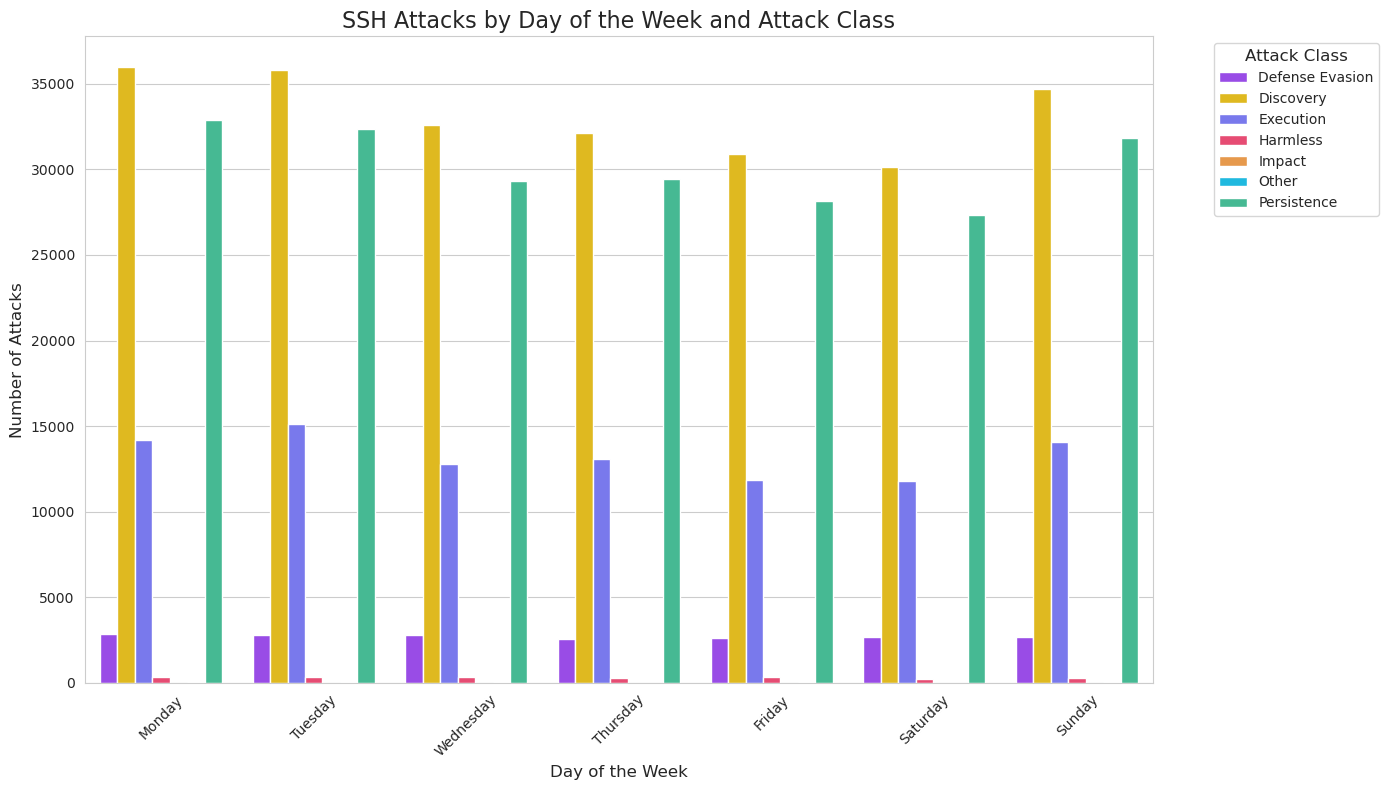

In [39]:
# Ensure the first_timestamp column is in datetime format (if not already)
SSH_Attacks['first_timestamp'] = pd.to_datetime(SSH_Attacks['first_timestamp'])
# Extract the day of the week from the first_timestamp column
SSH_Attacks['day_of_week'] = SSH_Attacks['first_timestamp'].dt.day_name()
# Explode the Set_Fingerprint column to create separate rows for each intent
SSH_Attacks_exploded = SSH_Attacks.explode('Set_Fingerprint')
# Group by day_of_week and Set_Fingerprint, and count the unique occurrences of first_timestamp
attack_counts_by_day_fingerprint = (
    SSH_Attacks_exploded.groupby(['day_of_week', 'Set_Fingerprint'])
    .agg(attack_count=('first_timestamp', 'nunique'))
    .reset_index()
)
# Ensure the days of the week are ordered correctly
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
attack_counts_by_day_fingerprint['day_of_week'] = pd.Categorical(attack_counts_by_day_fingerprint['day_of_week'], categories=ordered_days, ordered=True)
attack_counts_by_day_fingerprint = attack_counts_by_day_fingerprint.sort_values(['day_of_week', 'Set_Fingerprint'])

custom_palette = ['#9933FF','#FFCC00',  '#6666FF', '#FF3366', '#FF9933', '#00CCFF', '#33CC99']


# Plot the histogram with the new color palette
plt.figure(figsize=(14, 8))
sns.barplot(data=attack_counts_by_day_fingerprint, 
            x='day_of_week', 
            y='attack_count', 
            hue='Set_Fingerprint', 
            palette=custom_palette)

# Improve plot aesthetics
plt.title('SSH Attacks by Day of the Week and Attack Class', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Attack Class', fontsize=10, title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<center><b><font size=6>Session Analysis<b><center>

- Analyze `full_session`:
        - Count characters per session and plot its distribution.
        - Count words per session and plot its distribution.

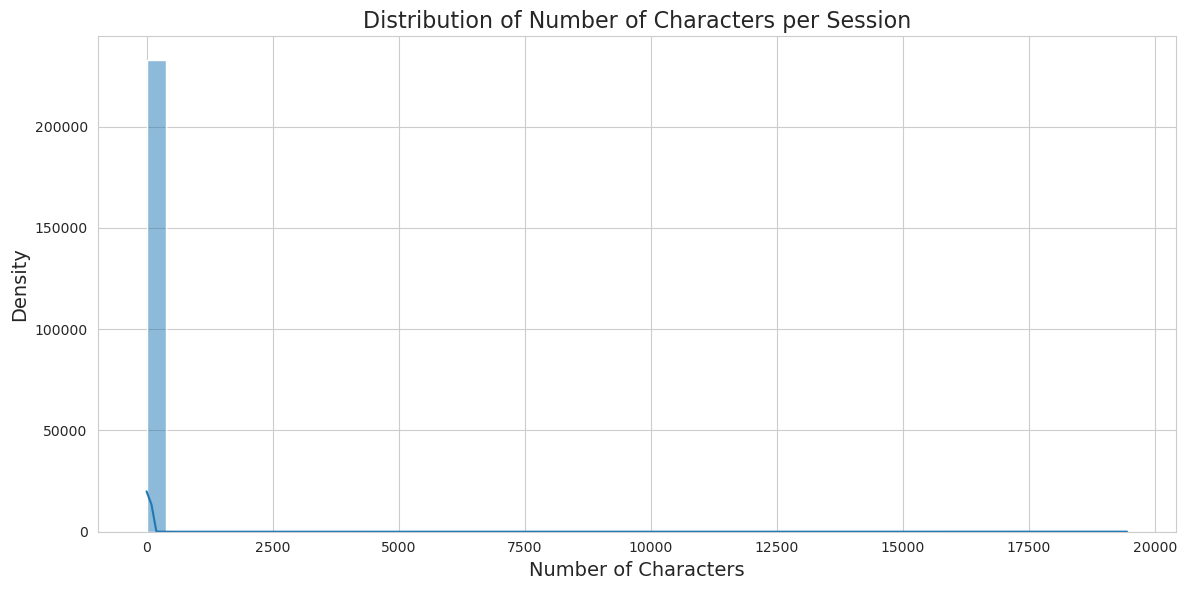

In [44]:
# Count characters per session and plot its distribution
SSH_Attacks['num_characters'] = SSH_Attacks['full_session'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(SSH_Attacks['num_characters'], kde=True, bins=50)
plt.title('Distribution of Number of Characters per Session', fontsize=16)
plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tight_layout()
plt.show()

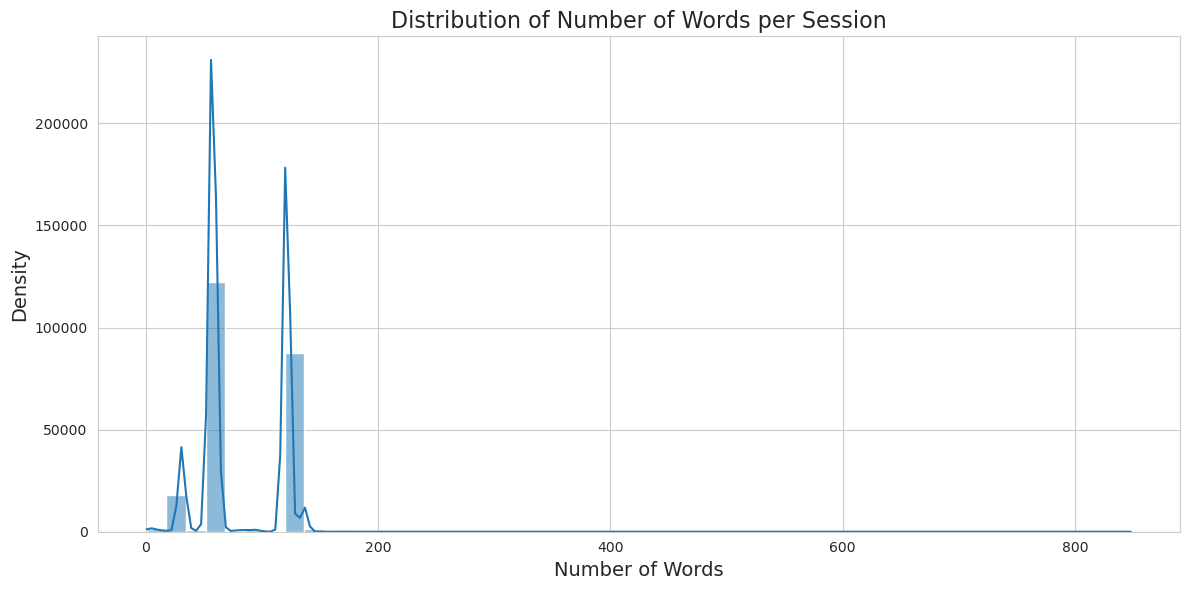

In [43]:
# Count words per session and plot its distribution
SSH_Attacks['num_words'] = SSH_Attacks['full_session'].apply(lambda x: len(' '.join(x).split()) if isinstance(x, list) else len(str(x).split()))
plt.figure(figsize=(12, 6))
sns.histplot(SSH_Attacks['num_words'], kde=True, bins=50)
plt.title('Distribution of Number of Words per Session', fontsize=16)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tight_layout()
plt.show()

- Extract the most common words using tokenization.
- Create visualizations: bar plots for word frequencies and word clouds.

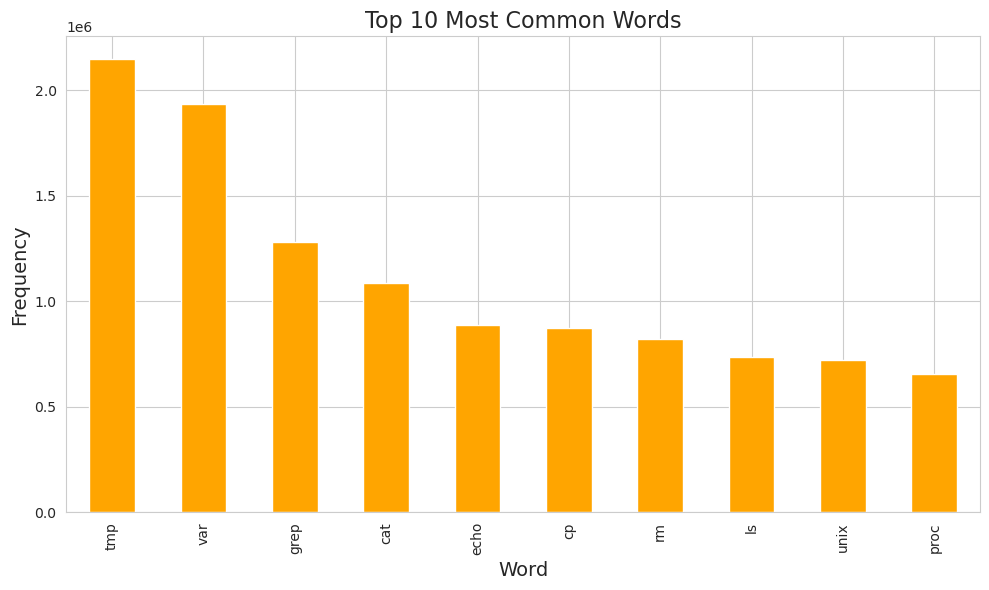

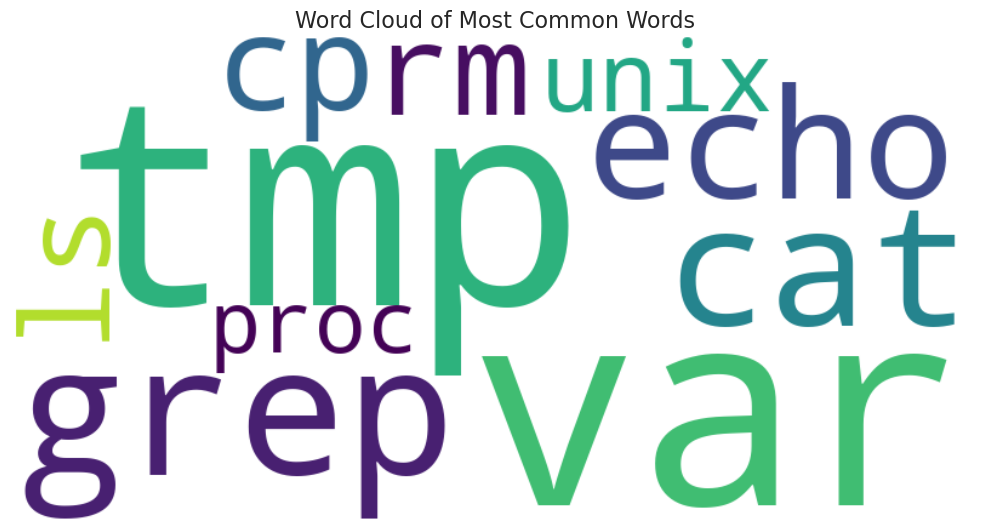

In [46]:
# Extract the most common words using tokenization
all_words = ' '.join([' '.join(map(str, x)) if isinstance(x, (list, np.ndarray)) else str(x) for x in SSH_Attacks['full_session']])
all_words_cleaned = [word for word in all_words.split() if word.isalnum()]
word_counts = pd.Series(all_words_cleaned).value_counts().head(10)

# Create visualizations: bar plots for word frequencies and word clouds
plt.figure(figsize=(10, 6))
word_counts.plot(kind='bar', color='orange')
plt.title('Top 10 Most Common Words', fontsize=16)
plt.xlabel('Word', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()

wordcloud = WordCloud(width=800, height=400, max_words=10, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words', fontsize=16)
plt.tight_layout()
plt.show()

<center><b><font size=6>Intents distribution<b><center>

- Explore the `Set_Fingerprint` column:
    - Count the occurrences of each intent.
    - Analyze the co-occurrence of intents per session.
    - Visualize with bar plots and co-occurrence heatmaps.

In [48]:
def extract_intents(entry):
    if isinstance(entry, np.ndarray):
        return entry.tolist()  # Convert numpy array to list
    elif isinstance(entry, list):
        return entry
    else:
        return []

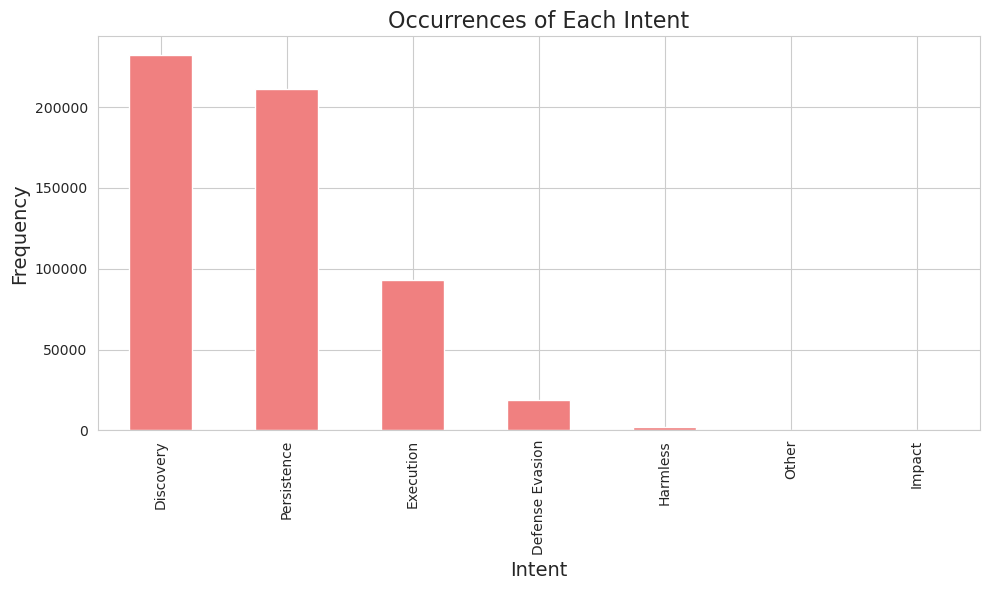

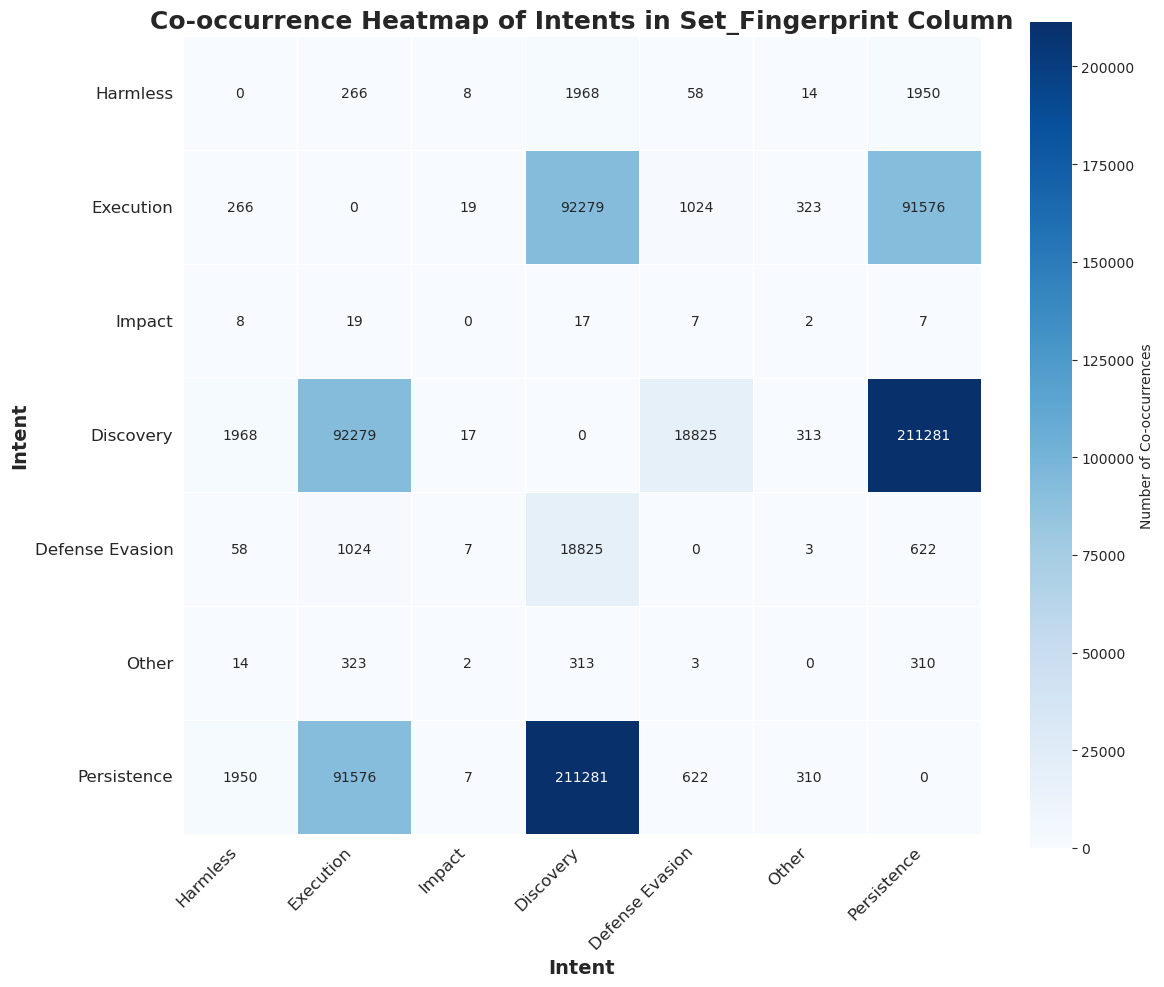

In [51]:
# Apply the extraction function to the Set_Fingerprint column
intents_list = SSH_Attacks['Set_Fingerprint'].apply(extract_intents)
SSH_Attacks['Intents'] = intents_list

# Count the occurrences of each intent
intent_counts = pd.Series(itertools.chain(*intents_list)).value_counts()
plt.figure(figsize=(10, 6))
intent_counts.plot(kind='bar', color='lightcoral')
plt.title('Occurrences of Each Intent', fontsize=16)
plt.xlabel('Intent', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()

# Create a dictionary to track the rows each intent appears in
intent_to_rows = {}
for idx, intents in enumerate(intents_list):
    if isinstance(intents, list) and len(intents) > 0:
        for intent in intents:
            if intent not in intent_to_rows:
                intent_to_rows[intent] = set()
            intent_to_rows[intent].add(idx)

# Create a set of all unique intents
all_intents = set(intent_to_rows.keys())

# Create a DataFrame that tracks the co-occurrence of intents
co_occurrence_matrix = pd.DataFrame(0, index=all_intents, columns=all_intents)
for intent1, rows1 in intent_to_rows.items():
    for intent2, rows2 in intent_to_rows.items():
        if intent1 != intent2:
            co_occurrence_count = len(rows1.intersection(rows2))
            co_occurrence_matrix.loc[intent1, intent2] = co_occurrence_count
            
# Plot the co-occurrence heatmap with cleaner formatting
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, annot=True, fmt='.0f', cmap='Blues', linewidths=0.5, square=True, cbar_kws={'label': 'Number of Co-occurrences'})
plt.title('Co-occurrence Heatmap of Intents in Set_Fingerprint Column', fontsize=18, fontweight='bold')
plt.xlabel('Intent', fontsize=14, fontweight='bold')
plt.ylabel('Intent', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

- Analyze temporal trends for intents (e.g., intent frequency over time).

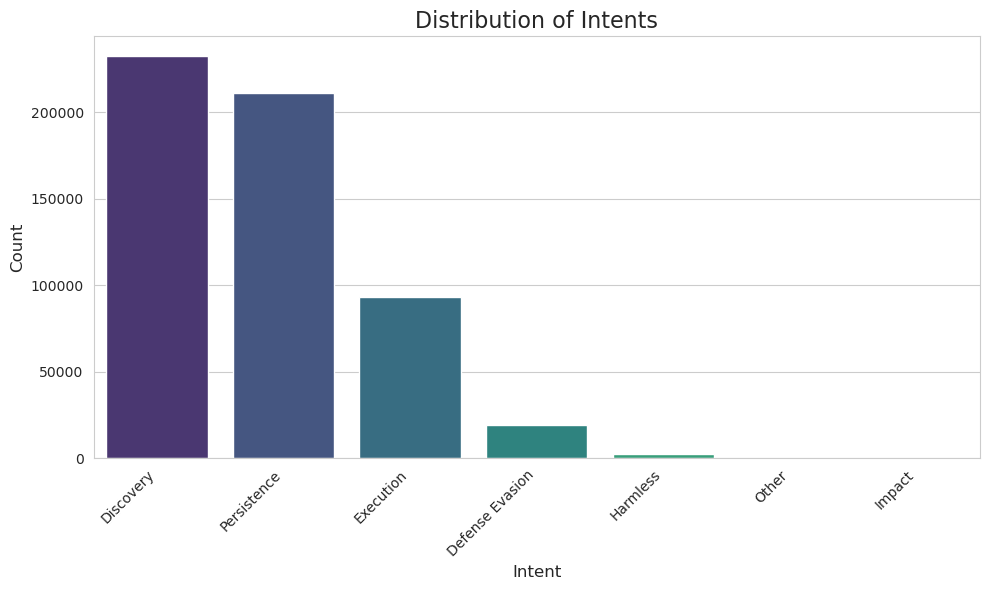

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


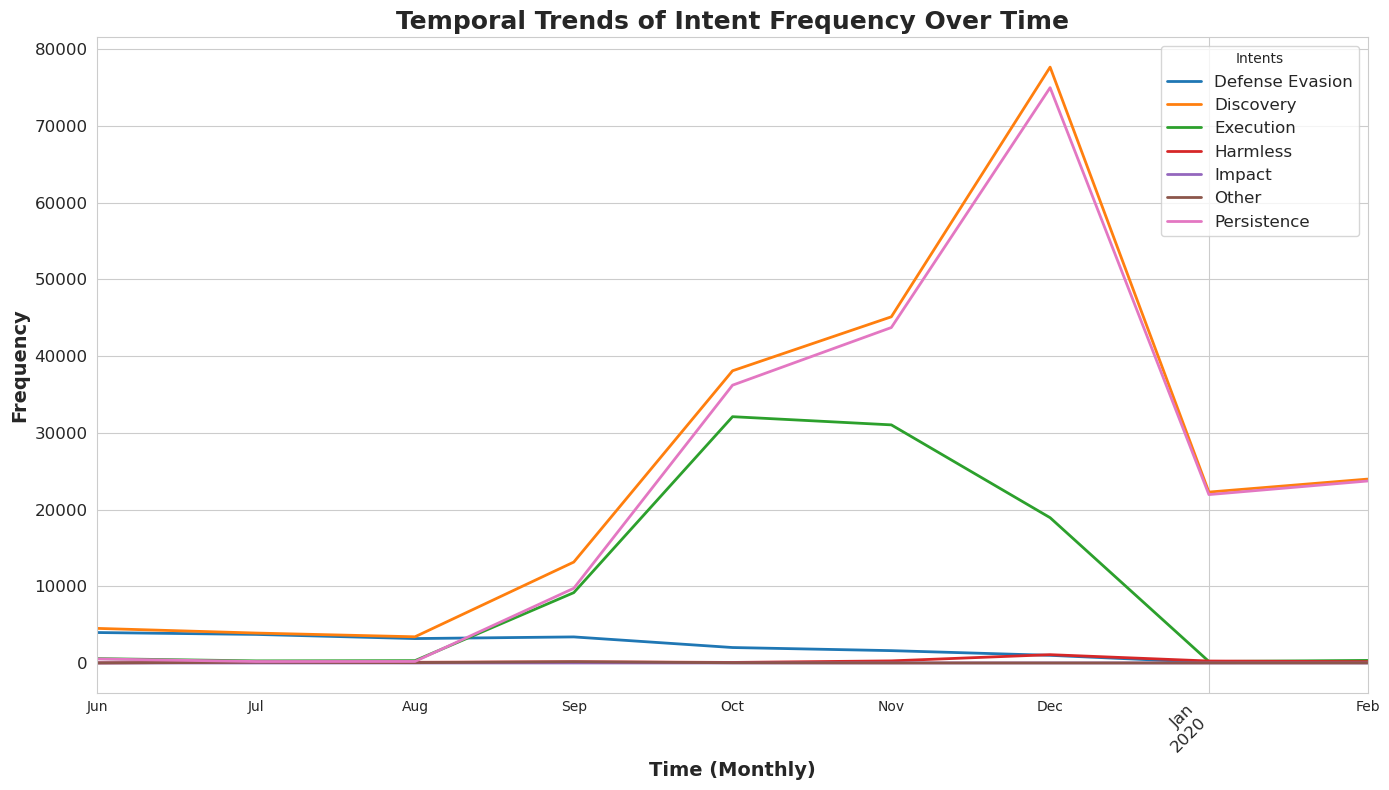

In [55]:
# Count occurrences of each intent
intent_counts = SSH_Attacks['Set_Fingerprint'].explode().value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=intent_counts.index, y=intent_counts.values, palette='viridis')
plt.title('Distribution of Intents', fontsize=16)
plt.xlabel('Intent', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze temporal trends for intents (e.g., intent frequency over time)
exploded_data = SSH_Attacks.explode('Intents')
intent_trends = exploded_data.groupby([exploded_data['first_timestamp'].dt.to_period('M'), 'Intents']).size().reset_index(name='Count')
intent_trends_pivot = intent_trends.pivot(index='first_timestamp', columns='Intents', values='Count').fillna(0)
plt.figure(figsize=(14, 8))
intent_trends_pivot.plot(ax=plt.gca(), linewidth=2)
plt.title('Temporal Trends of Intent Frequency Over Time', fontsize=18, fontweight='bold')
plt.xlabel('Time (Monthly)', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.legend(title='Intents', fontsize=12)
plt.tight_layout()
plt.show()

<center><b><font size=6>Text Representation<b><center>

- Convert `full_session` to numerical formats:
     - Implement Bag-of-Words (BoW).
     - Compute TF-IDF for each word and associate with sessions.
- Store the preprocessed features for supervised learning.

Evaluation of Bag-of-Words Model:
                                                                 precision    recall  f1-score   support

                                      Defense Evasion Discovery       0.99      0.98      0.98      3543
                            Defense Evasion Discovery Execution       0.65      0.58      0.62        62
                Defense Evasion Discovery Execution Persistence       0.80      0.65      0.72       102
                 Defense Evasion Discovery Harmless Persistence       0.00      0.00      0.00         5
                          Defense Evasion Discovery Persistence       0.00      0.00      0.00        13
                                      Defense Evasion Execution       0.60      0.87      0.71        31
                               Defense Evasion Execution Impact       0.00      1.00      0.00         0
                                                      Discovery       0.16      0.01      0.01       464
                    

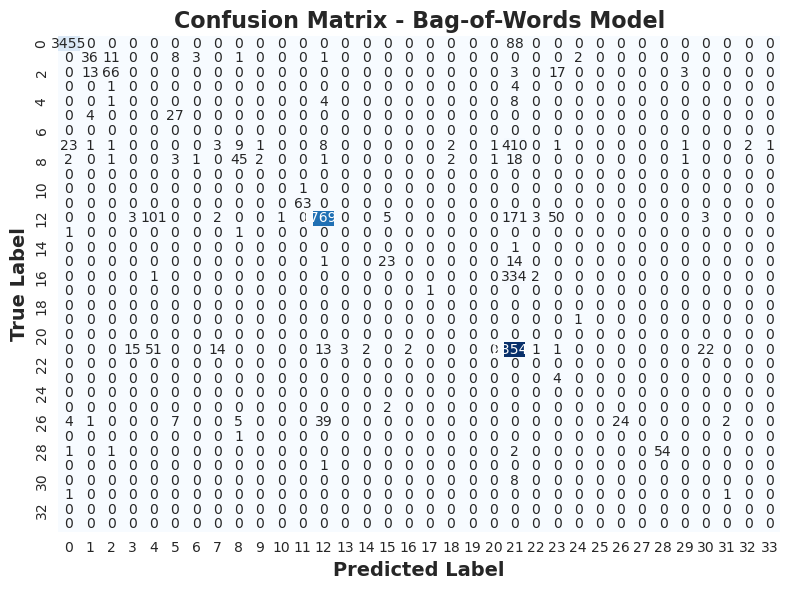

Evaluation of TF-IDF Model:
                                                          precision    recall  f1-score   support

                               Defense Evasion Discovery       0.98      0.98      0.98      3543
                     Defense Evasion Discovery Execution       0.60      0.05      0.09        62
         Defense Evasion Discovery Execution Persistence       0.64      0.92      0.76       102
          Defense Evasion Discovery Harmless Persistence       1.00      0.00      0.00         5
                   Defense Evasion Discovery Persistence       1.00      0.00      0.00        13
                               Defense Evasion Execution       0.63      0.39      0.48        31
                                               Discovery       1.00      0.01      0.02       464
                                     Discovery Execution       0.84      0.56      0.67        77
                               Discovery Execution Other       1.00      0.00      0.00  

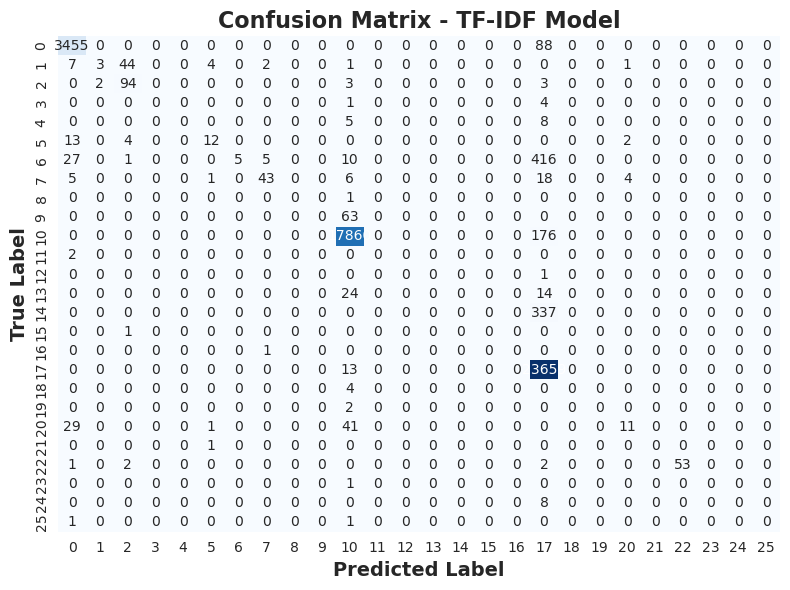

In [64]:
# Text Representation
# Bag-of-Words (BoW)
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(SSH_Attacks['full_session'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, (list, np.ndarray)) else str(x)))

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(SSH_Attacks['full_session'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, (list, np.ndarray)) else str(x)))


# Example analysis with the extracted features
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, SSH_Attacks['Intents'].apply(lambda x: ' '.join(x) if isinstance(x, list) else ''), test_size=0.2, random_state=42)
model_bow = MultinomialNB()
model_bow.fit(X_train_bow, y_train)
y_pred_bow = model_bow.predict(X_test_bow)

print("Evaluation of Bag-of-Words Model:")
print(classification_report(y_test, y_pred_bow, zero_division=1))
conf_matrix_bow = confusion_matrix(y_test, y_pred_bow)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_bow, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix - Bag-of-Words Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# TF-IDF Model
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, SSH_Attacks['Intents'].apply(lambda x: ' '.join(x) if isinstance(x, list) else ''), test_size=0.2, random_state=42)
model_tfidf = MultinomialNB()
model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

print("Evaluation of TF-IDF Model:")
print(classification_report(y_test, y_pred_tfidf, zero_division=1))
conf_matrix_tfidf = confusion_matrix(y_test, y_pred_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tfidf, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix - TF-IDF Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

<center><b><font size=6>Error Reporting<b><center>

- Document potential misclassified sessions and examples.